### Strategy creation - technical indicators

In [1]:
## This strategy is an all-in technical indicator trader.
## First step is to define technical indicators
## Second step is to calculate technical indicators
## Third step is to demean and standardise technical indicators, so that they can be used in statistical analysis
## Fourth step is to force stationarity upon them
##

In [2]:
import pandas as pd
import os
from datetime import datetime
convert_string_to_datetime = lambda x: datetime.strptime(x,"%Y-%m-%d")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from matplotlib import pyplot as plt

### Parameters

In [3]:
p_contract = "EURUSD"
window_range = range(7,90)
shift_range = range(2,30)
alph_high_range = [0.6,0.7,0.8,0.9,0.95]
alph_low_range = [0.1,0.2,0.3,0.4,0.5]

### Define technical indicators

In [4]:
## Form of function = "calc_"+ indicator name in x / y variables.

indicator_list = ['momentum','rolling_avg_pct_change','RSI','forward_opportunity','ema','ema_dif']

def self_reference(f):
    f.__defaults__ = f.__defaults__[:-1] + (f,)
    return f

@self_reference
def calc_momentum(df,price,window,self=None):
    df['last_%s_momentum' % window] = (df[price] / df[price].shift(window))-1
    string = 'last_%s_momentum' % window
    return df,string

@self_reference
def calc_rolling_avg_pct_change(df,price,window,shift,self=None):
    string = "rolling_"+str(window)+"_avg_"+str(shift)+"_period_pct_change"
    df[string] = df[price].rolling(window).mean()
    df[string] = (df[string]/df[string].shift(shift))-1
    
    return df,string

@self_reference
def calc_rolling_avg(df,price,window,self=None):
    df['rolling_%s_avg_price' % window] = df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price' % window
    return df,string
 
@self_reference    
def calc_rolling_avg_price_dif(df,price,window,self=None):
    df['rolling_%s_avg_price_dif' % window] = df[price] - df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price_dif' % window
    return df,string

@self_reference
def calc_RSI(df,price,window,self=None):
    random = df.copy(deep = True)
    random['status'] = random[price] - random[price].shift(1)
    random['status'] = random['status'].apply(lambda x: "Up" if x > 0 else "Down")
    random['average_for_up'] = random['status'].apply(lambda x: 1 if x == "Up" else 0)
    random['average_for_down'] = random['status'].apply(lambda x: 0 if x == "Up" else 1)
    random['average_price_up'] = (random['price']-random['price'].shift(1)) * random['average_for_up']
    random['average_price_down'] = (random['price']-random['price'].shift(1))* random['average_for_down']*-1
    random['average_price_up'] = random['average_price_up'].apply(lambda x: None if x ==  0 else x )
    random['average_price_down'] = random['average_price_down'].apply(lambda x: None if x == 0 else x )
    random['last_%s_RSI' % window] = random['average_price_up'].rolling(window, min_periods =1).sum() / random['average_price_down'].rolling(window, min_periods =1).sum()
    df['last_%s_RSI' % window] = 1 - 1/(1+random['last_%s_RSI' % window])
    for item in range(0,window): ## Formula above will not give NANs for the first (window-1) terms as min_periods = 1.
        df.at[item,'last_%s_RSI' % window] = None
    output_string = "last_" + str(window)+"_RSI"
    
    return df,output_string

@self_reference
def calc_forward_opportunity(df,price,window,self=None):
    df['forward_%s_opportunity' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity' % window] = df['forward_%s_opportunity' % window].shift(-window) - df[price]
    string = 'forward_%s_opportunity' % window
    return df,string 



### specify function list; must be ordered:

def calc_ema(df,price,alph,self = None):
    df['last_%s_EMA' % window ] = df[price].ewm(alpha=alph).mean()
    string = 'last_%s_EMA' % window 
    return df,string

def calc_ema_cross(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    rider['dif'] = rider['dif'].apply(lambda x: 1 if x>0 else 0)
    rider['dif_lag'] = rider['dif'].shift(1)
    rider['dif_lag'] = rider['dif_lag'].apply(lambda x: 1 if x>0 else 0)
    rider['signal'] = rider['dif'] - rider['dif_lag']
    
    
    string = str(alph_high) + "_high_" + str(alph_low) + "_low_ema_cross"
    df[string] = rider['signal']
    return df,string


def calc_ema_diff(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    
    
    string = str(a) + "_high_" + str(b) + "_low_ema_dif"
    df[string] = rider['dif']
    return df,string


calc_momentum.type = "window"
calc_rolling_avg_pct_change.type = "window_shift"
calc_rolling_avg.type = "window"
calc_rolling_avg_price_dif.type = "window"
calc_RSI.type="window"
calc_forward_opportunity.type = "window"
calc_ema.type = "window"
calc_ema_cross.type = "alpha"
calc_ema_diff.type = "alpha"




### Define synthetic cluster dic

In [5]:
momentum_list = []
for window in window_range:
    string = 'last_%s_momentum' % window
    momentum_list.append(string)

rolling_avg_pct_change_list = []
for window in window_range:
    for shift in shift_range:
        string = "rolling_"+str(window)+"_avg_"+str(shift)+"_period_pct_change"
        rolling_avg_pct_change_list.append(string)

rolling_avg_list = []
for window in window_range:
    string = 'rolling_%s_avg_price' % window
    rolling_avg_list.append(string)
    
rolling_avg_price_dif_list = []
for window in window_range:
    string = 'rolling_%s_avg_price_dif' % window
    rolling_avg_price_dif_list.append(string)
    
RSI_list = []
for window in window_range:
    string =  "last_" + str(window)+"_RSI"
    RSI_list.append(string)
    
EMA_list = []
for window in window_range:
    for a in alph_high_range:
        for b in alph_low_range:
            string = str(a) + "_high_" + str(b) + "_low_ema_dif"
            EMA_list.append(string)

synthetic_clstrs = {
    0:momentum_list,
    1:rolling_avg_pct_change_list,
    #2:rolling_avg_list,
    2:rolling_avg_price_dif_list,
    3:RSI_list,
    4: EMA_list
    

    
}
    
    

In [6]:
### Specify what indicators to use
### These variables should be iterable based on either a shift or a rolling window.It may be iterable multiple times
x_variables = ['momentum','rolling_avg_pct_change','rolling_avg_price_dif','RSI','ema_diff']
y_variables = ['forward_opportunity']
all_variables = x_variables + y_variables
x_dic = {}
for item in x_variables:
    x_dic[item] = eval("calc_"+str(item))
    
y_dic = {}
for item in y_variables:
    y_dic[item] = eval("calc_"+str(item))

### Upload data

In [7]:
## Directory params
p_file_path =  r"C:\Users\hugo.lu\repos\repos_backup\ib_insync\Raw data\\" + p_contract + "\\"
data_list = os.listdir(path=p_file_path)
data_sub_list = []
if len(data_list) == 0:
    print("Nothing in directory")
    directory_empty = True
else:
    for item in data_list:
        try:
            data_sub_list.append(datetime.strptime(item.split("_")[0],"%Y-%m-%d"))
        except:
            data_sub_list.append(datetime.strptime('1000-01-01',"%Y-%m-%d"))
### Take latest file            
    m = max(data_sub_list)
    index_out = [i for i, j in enumerate(data_sub_list) if j == m]

    print("The index of the latest data is: " + str(index_out))

    data_load_string = data_list[0]
    data_in = pd.read_csv(filepath_or_buffer = r'C:\Users\hugo.lu\repos\repos_backup\ib_insync\Raw data\\' + p_contract + "\\" + data_load_string

                         ,index_col=0)
    ### Convert date column to datetime64
    data_in['date'] = data_in['date'].astype(str) 
    data_in['date']=data_in['date'].apply(convert_string_to_datetime)

The index of the latest data is: [0]


In [8]:
data_columns = list(data_in.columns)
data_copy = data_in.copy(deep = True)
data_copy = data_copy.rename( columns = {
    
    'date': 'date',
    'open':'price',
    #'Ticker':'ticker'
    
})
data_copy['ticker'] = "EURUSD"
## Cast all relevant objects to floats

float_list = ['price','close']

for item in float_list:
    data_copy[item] = data_copy[item].astype('float64')
    ## Cast all relevant objects to dates

float_list = ['date']
for item in float_list:
    data_copy[item] = pd.to_datetime(data_copy[item])

### Calculate indicators

In [9]:
x_variables_actual = []
y_variables_actual = []

for key,value in x_dic.items():
    #print("calculating indicators for: " + str(key))
    if value.type == "window":
        for item in window_range:

            [data_copy,b] = value(data_copy,'price',item)
            x_variables_actual.append(b)
    elif value.type == "window_shift":
        for item in window_range:
            for jtem in shift_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                x_variables_actual.append(b)
    elif value.type == "alpha":
            for a in alph_high_range:
                for c in alph_low_range:
                    [data_copy,b] = value(data_copy,'price',a,c)
                    x_variables_actual.append(b)
    else:
        print("Functions specified incorrectly")
        break
            

for key,value in y_dic.items():
    #print("calculating indicators for: " + str(key))
    if value.type == "window":
        for item in window_range:

            [data_copy,b] = value(data_copy,'price',item)
            y_variables_actual.append(b)
    elif value.type == "window_shift":
        for jtem in shift_range:
            for item in window_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                y_variables_actual.append(b)
    else:
        print("Functions specified incorrectly")
        break

In [11]:
len(data_copy)

2593

In [10]:
all_variables_list = x_variables_actual+y_variables_actual
data_reg = data_copy[all_variables_list]
data_reg = data_reg.dropna() ### Simply dropna as data availability is not an issue

### Regularise data

In [11]:
data_mean = list(data_reg.mean())
data_std = list(data_reg.std())
data_reg = (data_reg - data_mean)/data_std


### Test for stationarity and remove non-stationary variables

In [13]:

## Test for stationarity; keep the columns at a given sig level
five_pct_confidence_adf = []
one_pct_confidence_adf = []
not_accepted_adf = []

from statsmodels.tsa.stattools import adfuller
#series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
for item in x_variables_actual:
    X = data_reg[item]
    result = adfuller(X)
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    #print('Critical Values:')
    #for key, value in result[4].items():
    #    print('\t%s: %.3f' % (key, value))
    if result[0] < -3.434:
        five_pct_confidence_adf.append(item)
        one_pct_confidence_adf.append(item)
    elif result[0] < -2.863:
        five_pct_confidence_adf.append(item)
    else:
        not_accepted_adf.append(item)
print("Five pct has retention of: " + str(len(five_pct_confidence_adf)/len(list(data_reg.columns))))
print("One pct has retention of: " + str(len(one_pct_confidence_adf)/len(list(data_reg.columns))))

Five pct has retention of: 0.969041402461768
One pct has retention of: 0.9474076837001119


In [14]:
stationary_data = data_reg[one_pct_confidence_adf+y_variables_actual]

### Clustering helper functions

In [15]:
 def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
     from sklearn.cluster import KMeans
     from sklearn.metrics import silhouette_samples
     dist,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series() # distance matrix
     for init in range(n_init):
            print(init)
            for i in range(2,maxNumClusters+1): # find optimal num clusters
                #print("the max clusters are: " + str (maxNumClusters+1))
                print("CHECKING CLUSTERS FOR: " + str(i))
                kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1)
                kmeans_=kmeans_.fit(dist)
                silh_=silhouette_samples(dist,kmeans_.labels_)
                stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
                if np.isnan(stat[1]) or stat[0]>stat[1]:
                    silh,kmeans=silh_,kmeans_
     n_clusters = len( np.unique( kmeans.labels_ ) )
     newIdx=np.argsort(kmeans.labels_)
     corr1=corr0.iloc[newIdx] # reorder rows
     corr1=corr1.iloc[:,newIdx] # reorder columns
     clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0] ].tolist() for i in np.unique(kmeans.labels_) } # cluster members
     silh=pd.Series(silh,index=dist.index)
     return corr1,clstrs,silh

    #------------------------------------------------------------------------------
def makeNewOutputs2(corr0,clstrs,clstrs2):
    from sklearn.metrics import silhouette_samples
    clstrsNew,newIdx={},[]
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    map(newIdx.extend, clstrsNew.values())
    corrNew=corr0.loc[newIdx,newIdx]

    dist=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs=[dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(dist,kmeans_labels),index=dist.index)
    return corrNew,clstrsNew,silhNew

def makeNewOutputs(corr0,clstrs,clstrs2):
    clstrsNew={}
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs[i])
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())]=list(clstrs2[i])
    newIdx=[j for i in clstrsNew for j in clstrsNew[i]]
    corrNew=corr0.loc[newIdx,newIdx]
    x=((1-corr0.fillna(0))/2.)**.5
    kmeans_labels=np.zeros(len(x.columns))
    for i in clstrsNew.keys():
        idxs=[x.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs]=i
    silhNew=pd.Series(silhouette_samples(x,kmeans_labels),
    index=x.index)
    return corrNew,clstrsNew,silhNew
    #------------------------------------------------------------------------------
def clusterKMeansTop(corr0,maxNumClusters=10,n_init=10):
    corr1,clstrs,silh=clusterKMeansBase(corr0,maxNumClusters=min(maxNumClusters,corr0.shape[1]-1),n_init=n_init)
    clusterTstats={i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean=sum(clusterTstats.values())/float(len(clusterTstats.values()))
    redoClusters=[i for i in clusterTstats.keys() if clusterTstats[i]<tStatMean]
    if len(redoClusters)<=2:
        return corr1,clstrs,silh
    else:
        keysRedo=[];#map(keysRedo.extend,[clstrs[i] for i in redoClusters])
        for item in redoClusters:
            for j in clstrs[item]:
                keysRedo.append(j)
        corrTmp=corr0.loc[keysRedo,keysRedo]
        meanRedoTstat=np.mean([clusterTstats[i] for i in redoClusters])
        corr2,clstrs2,silh2=clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters,corrTmp.shape[1]-1),n_init=n_init)
        # Make new outputs, if necessary
        #print("The length of the  inner returned matrix is: " + str(len(corr2)))
        corrNew,clstrsNew,silhNew=makeNewOutputs(corr0, {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters},clstrs2)
        #print("The length of the  new cov matrix is: " + str(len(corrNew)))
        newTstatMean=np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean<=meanRedoTstat:
            #print("Returning old correlation matrix")
            return corr1,clstrs,silh
        else:
            #print("Returning new correlation matrix")
            return corrNew,clstrsNew,silhNew

#import numpy as np,pandas as pd
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
#------------------------------------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr
#------------------------------------------------------------------------------
def getCovSub(nObs,nCols,sigma,random_state=None):
    # Sub correl matrix
    rng = check_random_state(random_state)
    if nCols==1:return np.ones((1,1))
    ar0=rng.normal(size=(nObs,1))
    ar0=np.repeat(ar0,nCols,axis=1)
    ar0+=rng.normal(scale=sigma,size=ar0.shape)
    ar0=np.cov(ar0,rowvar=False)
    return ar0
#------------------------------------------------------------------------------
def getRndBlockCov(nCols,nBlocks,minBlockSize=1,sigma=1.,random_state=None):
    # Generate a random correlation matrix with a given number of blocks
    rng = check_random_state(random_state)
    parts=rng.choice(range(1,nCols-(minBlockSize-1)*nBlocks),nBlocks-1,replace=False)
    parts.sort()
    parts=np.append(parts,nCols-(minBlockSize-1)*nBlocks)
    parts=np.append(parts[0],np.diff( parts )) - 1 + minBlockSize
    cov=None
    for nCols_ in parts:
        cov_=getCovSub(int(max(nCols_*(nCols_+1)/2.,100)),nCols_,sigma,random_state=rng)
        if cov is None:cov=cov_.copy()
        else:cov=block_diag(cov,cov_)
    return cov
#------------------------------------------------------------------------------
def randomBlockCorr(nCols,nBlocks,random_state=None,minBlockSize=1):
    # Form block covar
    rng = check_random_state(random_state)
    cov0=getRndBlockCov(nCols,nBlocks,minBlockSize=minBlockSize,\
    sigma=.5,random_state=rng) # perfect block corr
    cov1=getRndBlockCov(nCols,1,minBlockSize=minBlockSize,\
    sigma=1.,random_state=rng) # add noise
    cov0+=cov1
    corr0=cov2corr(cov0)
    corr0=pd.DataFrame(corr0)
    return corr0

def getTestData(n_features=100,n_informative=25,n_redundant=25,
    n_samples=10000,random_state=0,sigmaStd=.0):
    # generate a random dataset for a classification problem
    
    np.random.seed(random_state)
    X,y=make_classification(n_samples=n_samples,
    n_features=n_features-n_redundant,
    n_informative=n_informative,n_redundant=0,shuffle=False,
    random_state=random_state)
    cols=['I_'+str(i) for i in range(n_informative)]
    cols+=['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]
    X,y=pd.DataFrame(X,columns=cols),pd.Series(y)
    i=np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)]=X['I_'+str(j)]+np.random.normal(size=X.shape[0])*sigmaStd
    return X,y

#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in \
    enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),
    'std':df0.std()*df0.shape[0]**-.5},axis=1) # CLT
    imp/=imp['mean'].sum()
    return imp
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDA(clf,X,y,n_splits=10):
# feat importance based on OOS score reduction
    
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0) # the fit occurs here
        prob=fit.predict_proba(X1) # prediction before shuffling
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # shuffle one column
            prob=fit.predict_proba(X1_) # prediction after shuffling
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT
    return imp


def groupMeanStd(df0,clstrs):
    out=pd.DataFrame(columns=['mean','std'])
    for i,j in clstrs.items():
        df1=df0[j].sum(axis=1)
        out.loc['C_'+str(i),'mean']=df1.mean()
        out.loc['C_'+str(i),'std']=df1.std()*df1.shape[0]**-.5
    return out
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def featImpMDI_Clustered(fit,featNames,clstrs):
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=groupMeanStd(df0,clstrs)
    imp/=imp['mean'].sum()
    return imp


def featImpMDA_Clustered(clf,X,y,clstrs,n_splits=10):

    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=clstrs.keys())
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0)
        prob=fit.predict_proba(X1)
        scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
        for j in scr1.columns:
            X1_=X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) # shuffle cluster
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    imp.index=['C_'+str(i) for i in imp.index]
    return imp

### Find optimal clusters for given y variables

In [16]:
from sklearn.datasets import make_classification
import numpy as np,pandas as pd,seaborn as sns
import statsmodels.discrete.discrete_model as sm

X = stationary_data[one_pct_confidence_adf]
y = stationary_data[y_variables_actual]['forward_7_opportunity']
try:
    y = y.iloc[:,0].apply(lambda x: 1 if x>0 else 0 )
except:
    y = y.apply(lambda x: 1 if x>0 else 0 )
#ols=sm.Logit(y,X).fit()

In [17]:
clusters_vars = []
fc = 0
for a,b in synthetic_clstrs.items():
    for item in b:
        clusters_vars.append(item)
        fc+=1

x_vars = len(list(X.columns))
print(str(x_vars))

2540


In [18]:
fc = 0
for key in synthetic_clstrs.items():
    print(len(list(synthetic_clstrs[key[0]])))
    fc += len(list(synthetic_clstrs[key[0]]))

83
2324
83
83
2075


In [19]:
fc

4648

In [20]:
print(len(clusters_vars))
print("We need to remove " + str(len(clusters_vars) - x_vars) + " variables")

4648
We need to remove 2108 variables


In [21]:
counter = 0 
remove = 0
for key in synthetic_clstrs.items():
    rider = (list(synthetic_clstrs[key[0]]))
    for item in rider:
        counter +=1
        if item in list(X.columns):
            print("Keeping: " + str(item))
        elif item not in list(X.columns):
            print("Removing: " + str(item))
            synthetic_clstrs[key[0]].remove(item)
            remove +=1
        else:
            print("Removing: " + str(item))
            synthetic_clstrs[key[0]].remove(item)
            remove +=1
            
            

Keeping: last_7_momentum
Keeping: last_8_momentum
Keeping: last_9_momentum
Keeping: last_10_momentum
Keeping: last_11_momentum
Keeping: last_12_momentum
Keeping: last_13_momentum
Keeping: last_14_momentum
Keeping: last_15_momentum
Keeping: last_16_momentum
Keeping: last_17_momentum
Keeping: last_18_momentum
Keeping: last_19_momentum
Keeping: last_20_momentum
Keeping: last_21_momentum
Keeping: last_22_momentum
Keeping: last_23_momentum
Keeping: last_24_momentum
Keeping: last_25_momentum
Keeping: last_26_momentum
Keeping: last_27_momentum
Keeping: last_28_momentum
Keeping: last_29_momentum
Keeping: last_30_momentum
Keeping: last_31_momentum
Keeping: last_32_momentum
Keeping: last_33_momentum
Keeping: last_34_momentum
Keeping: last_35_momentum
Keeping: last_36_momentum
Keeping: last_37_momentum
Keeping: last_38_momentum
Keeping: last_39_momentum
Keeping: last_40_momentum
Keeping: last_41_momentum
Keeping: last_42_momentum
Keeping: last_43_momentum
Keeping: last_44_momentum
Keeping: last_4

Keeping: rolling_21_avg_19_period_pct_change
Keeping: rolling_21_avg_20_period_pct_change
Keeping: rolling_21_avg_21_period_pct_change
Keeping: rolling_21_avg_22_period_pct_change
Keeping: rolling_21_avg_23_period_pct_change
Keeping: rolling_21_avg_24_period_pct_change
Keeping: rolling_21_avg_25_period_pct_change
Keeping: rolling_21_avg_26_period_pct_change
Keeping: rolling_21_avg_27_period_pct_change
Keeping: rolling_21_avg_28_period_pct_change
Keeping: rolling_21_avg_29_period_pct_change
Keeping: rolling_22_avg_2_period_pct_change
Keeping: rolling_22_avg_3_period_pct_change
Keeping: rolling_22_avg_4_period_pct_change
Keeping: rolling_22_avg_5_period_pct_change
Keeping: rolling_22_avg_6_period_pct_change
Keeping: rolling_22_avg_7_period_pct_change
Keeping: rolling_22_avg_8_period_pct_change
Keeping: rolling_22_avg_9_period_pct_change
Keeping: rolling_22_avg_10_period_pct_change
Keeping: rolling_22_avg_11_period_pct_change
Keeping: rolling_22_avg_12_period_pct_change
Keeping: rolling_2

Keeping: rolling_38_avg_20_period_pct_change
Keeping: rolling_38_avg_21_period_pct_change
Keeping: rolling_38_avg_22_period_pct_change
Keeping: rolling_38_avg_23_period_pct_change
Keeping: rolling_38_avg_24_period_pct_change
Keeping: rolling_38_avg_25_period_pct_change
Keeping: rolling_38_avg_26_period_pct_change
Removing: rolling_38_avg_27_period_pct_change
Removing: rolling_38_avg_28_period_pct_change
Keeping: rolling_38_avg_29_period_pct_change
Keeping: rolling_39_avg_2_period_pct_change
Keeping: rolling_39_avg_3_period_pct_change
Keeping: rolling_39_avg_4_period_pct_change
Keeping: rolling_39_avg_5_period_pct_change
Keeping: rolling_39_avg_6_period_pct_change
Keeping: rolling_39_avg_7_period_pct_change
Keeping: rolling_39_avg_8_period_pct_change
Keeping: rolling_39_avg_9_period_pct_change
Keeping: rolling_39_avg_10_period_pct_change
Keeping: rolling_39_avg_11_period_pct_change
Keeping: rolling_39_avg_12_period_pct_change
Keeping: rolling_39_avg_13_period_pct_change
Keeping: rolling

Keeping: rolling_51_avg_19_period_pct_change
Keeping: rolling_51_avg_20_period_pct_change
Keeping: rolling_51_avg_21_period_pct_change
Keeping: rolling_51_avg_22_period_pct_change
Keeping: rolling_51_avg_23_period_pct_change
Keeping: rolling_51_avg_24_period_pct_change
Keeping: rolling_51_avg_25_period_pct_change
Keeping: rolling_51_avg_26_period_pct_change
Keeping: rolling_51_avg_27_period_pct_change
Keeping: rolling_51_avg_28_period_pct_change
Keeping: rolling_51_avg_29_period_pct_change
Keeping: rolling_52_avg_2_period_pct_change
Keeping: rolling_52_avg_3_period_pct_change
Keeping: rolling_52_avg_4_period_pct_change
Keeping: rolling_52_avg_5_period_pct_change
Keeping: rolling_52_avg_6_period_pct_change
Keeping: rolling_52_avg_7_period_pct_change
Keeping: rolling_52_avg_8_period_pct_change
Keeping: rolling_52_avg_9_period_pct_change
Keeping: rolling_52_avg_10_period_pct_change
Keeping: rolling_52_avg_11_period_pct_change
Keeping: rolling_52_avg_12_period_pct_change
Keeping: rolling_5

Keeping: rolling_66_avg_23_period_pct_change
Keeping: rolling_66_avg_24_period_pct_change
Keeping: rolling_66_avg_25_period_pct_change
Keeping: rolling_66_avg_26_period_pct_change
Keeping: rolling_66_avg_27_period_pct_change
Keeping: rolling_66_avg_28_period_pct_change
Keeping: rolling_66_avg_29_period_pct_change
Keeping: rolling_67_avg_2_period_pct_change
Keeping: rolling_67_avg_3_period_pct_change
Keeping: rolling_67_avg_4_period_pct_change
Keeping: rolling_67_avg_5_period_pct_change
Keeping: rolling_67_avg_6_period_pct_change
Keeping: rolling_67_avg_7_period_pct_change
Keeping: rolling_67_avg_8_period_pct_change
Keeping: rolling_67_avg_9_period_pct_change
Keeping: rolling_67_avg_10_period_pct_change
Keeping: rolling_67_avg_11_period_pct_change
Keeping: rolling_67_avg_12_period_pct_change
Keeping: rolling_67_avg_13_period_pct_change
Keeping: rolling_67_avg_14_period_pct_change
Keeping: rolling_67_avg_15_period_pct_change
Keeping: rolling_67_avg_16_period_pct_change
Keeping: rolling_6

Keeping: rolling_76_avg_4_period_pct_change
Keeping: rolling_76_avg_5_period_pct_change
Keeping: rolling_76_avg_6_period_pct_change
Keeping: rolling_76_avg_7_period_pct_change
Keeping: rolling_76_avg_8_period_pct_change
Keeping: rolling_76_avg_9_period_pct_change
Keeping: rolling_76_avg_10_period_pct_change
Keeping: rolling_76_avg_11_period_pct_change
Keeping: rolling_76_avg_12_period_pct_change
Keeping: rolling_76_avg_13_period_pct_change
Keeping: rolling_76_avg_14_period_pct_change
Keeping: rolling_76_avg_15_period_pct_change
Keeping: rolling_76_avg_16_period_pct_change
Keeping: rolling_76_avg_17_period_pct_change
Keeping: rolling_76_avg_18_period_pct_change
Keeping: rolling_76_avg_19_period_pct_change
Keeping: rolling_76_avg_20_period_pct_change
Keeping: rolling_76_avg_21_period_pct_change
Keeping: rolling_76_avg_22_period_pct_change
Keeping: rolling_76_avg_23_period_pct_change
Keeping: rolling_76_avg_24_period_pct_change
Keeping: rolling_76_avg_25_period_pct_change
Keeping: rolling

Keeping: rolling_89_avg_14_period_pct_change
Keeping: rolling_89_avg_15_period_pct_change
Keeping: rolling_89_avg_16_period_pct_change
Keeping: rolling_89_avg_17_period_pct_change
Keeping: rolling_89_avg_18_period_pct_change
Keeping: rolling_89_avg_19_period_pct_change
Keeping: rolling_89_avg_20_period_pct_change
Keeping: rolling_89_avg_21_period_pct_change
Keeping: rolling_89_avg_22_period_pct_change
Keeping: rolling_89_avg_23_period_pct_change
Keeping: rolling_89_avg_24_period_pct_change
Keeping: rolling_89_avg_25_period_pct_change
Keeping: rolling_89_avg_26_period_pct_change
Removing: rolling_89_avg_27_period_pct_change
Removing: rolling_89_avg_28_period_pct_change
Removing: rolling_89_avg_29_period_pct_change
Keeping: rolling_7_avg_price_dif
Keeping: rolling_8_avg_price_dif
Keeping: rolling_9_avg_price_dif
Keeping: rolling_10_avg_price_dif
Keeping: rolling_11_avg_price_dif
Keeping: rolling_12_avg_price_dif
Keeping: rolling_13_avg_price_dif
Keeping: rolling_14_avg_price_dif
Keeping:

Removing: last_11_0.7_high_0.1_low_ema_dif
Removing: last_11_0.7_high_0.2_low_ema_dif
Removing: last_11_0.7_high_0.3_low_ema_dif
Removing: last_11_0.7_high_0.4_low_ema_dif
Removing: last_11_0.7_high_0.5_low_ema_dif
Removing: last_11_0.8_high_0.1_low_ema_dif
Removing: last_11_0.8_high_0.2_low_ema_dif
Removing: last_11_0.8_high_0.3_low_ema_dif
Removing: last_11_0.8_high_0.4_low_ema_dif
Removing: last_11_0.8_high_0.5_low_ema_dif
Removing: last_11_0.9_high_0.1_low_ema_dif
Removing: last_11_0.9_high_0.2_low_ema_dif
Removing: last_11_0.9_high_0.3_low_ema_dif
Removing: last_11_0.9_high_0.4_low_ema_dif
Removing: last_11_0.9_high_0.5_low_ema_dif
Removing: last_11_0.95_high_0.1_low_ema_dif
Removing: last_11_0.95_high_0.2_low_ema_dif
Removing: last_11_0.95_high_0.3_low_ema_dif
Removing: last_11_0.95_high_0.4_low_ema_dif
Removing: last_11_0.95_high_0.5_low_ema_dif
Removing: last_12_0.6_high_0.1_low_ema_dif
Removing: last_12_0.6_high_0.2_low_ema_dif
Removing: last_12_0.6_high_0.3_low_ema_dif
Removi

Removing: last_27_0.8_high_0.5_low_ema_dif
Removing: last_27_0.9_high_0.1_low_ema_dif
Removing: last_27_0.9_high_0.2_low_ema_dif
Removing: last_27_0.9_high_0.3_low_ema_dif
Removing: last_27_0.9_high_0.4_low_ema_dif
Removing: last_27_0.9_high_0.5_low_ema_dif
Removing: last_27_0.95_high_0.1_low_ema_dif
Removing: last_27_0.95_high_0.2_low_ema_dif
Removing: last_27_0.95_high_0.3_low_ema_dif
Removing: last_27_0.95_high_0.4_low_ema_dif
Removing: last_27_0.95_high_0.5_low_ema_dif
Removing: last_28_0.6_high_0.1_low_ema_dif
Removing: last_28_0.6_high_0.2_low_ema_dif
Removing: last_28_0.6_high_0.3_low_ema_dif
Removing: last_28_0.6_high_0.4_low_ema_dif
Removing: last_28_0.6_high_0.5_low_ema_dif
Removing: last_28_0.7_high_0.1_low_ema_dif
Removing: last_28_0.7_high_0.2_low_ema_dif
Removing: last_28_0.7_high_0.3_low_ema_dif
Removing: last_28_0.7_high_0.4_low_ema_dif
Removing: last_28_0.7_high_0.5_low_ema_dif
Removing: last_28_0.8_high_0.1_low_ema_dif
Removing: last_28_0.8_high_0.2_low_ema_dif
Removi

Removing: last_36_0.8_high_0.3_low_ema_dif
Removing: last_36_0.8_high_0.4_low_ema_dif
Removing: last_36_0.8_high_0.5_low_ema_dif
Removing: last_36_0.9_high_0.1_low_ema_dif
Removing: last_36_0.9_high_0.2_low_ema_dif
Removing: last_36_0.9_high_0.3_low_ema_dif
Removing: last_36_0.9_high_0.4_low_ema_dif
Removing: last_36_0.9_high_0.5_low_ema_dif
Removing: last_36_0.95_high_0.1_low_ema_dif
Removing: last_36_0.95_high_0.2_low_ema_dif
Removing: last_36_0.95_high_0.3_low_ema_dif
Removing: last_36_0.95_high_0.4_low_ema_dif
Removing: last_36_0.95_high_0.5_low_ema_dif
Removing: last_37_0.6_high_0.1_low_ema_dif
Removing: last_37_0.6_high_0.2_low_ema_dif
Removing: last_37_0.6_high_0.3_low_ema_dif
Removing: last_37_0.6_high_0.4_low_ema_dif
Removing: last_37_0.6_high_0.5_low_ema_dif
Removing: last_37_0.7_high_0.1_low_ema_dif
Removing: last_37_0.7_high_0.2_low_ema_dif
Removing: last_37_0.7_high_0.3_low_ema_dif
Removing: last_37_0.7_high_0.4_low_ema_dif
Removing: last_37_0.7_high_0.5_low_ema_dif
Removi

Removing: last_50_0.95_high_0.4_low_ema_dif
Removing: last_50_0.95_high_0.5_low_ema_dif
Removing: last_51_0.6_high_0.1_low_ema_dif
Removing: last_51_0.6_high_0.2_low_ema_dif
Removing: last_51_0.6_high_0.3_low_ema_dif
Removing: last_51_0.6_high_0.4_low_ema_dif
Removing: last_51_0.6_high_0.5_low_ema_dif
Removing: last_51_0.7_high_0.1_low_ema_dif
Removing: last_51_0.7_high_0.2_low_ema_dif
Removing: last_51_0.7_high_0.3_low_ema_dif
Removing: last_51_0.7_high_0.4_low_ema_dif
Removing: last_51_0.7_high_0.5_low_ema_dif
Removing: last_51_0.8_high_0.1_low_ema_dif
Removing: last_51_0.8_high_0.2_low_ema_dif
Removing: last_51_0.8_high_0.3_low_ema_dif
Removing: last_51_0.8_high_0.4_low_ema_dif
Removing: last_51_0.8_high_0.5_low_ema_dif
Removing: last_51_0.9_high_0.1_low_ema_dif
Removing: last_51_0.9_high_0.2_low_ema_dif
Removing: last_51_0.9_high_0.3_low_ema_dif
Removing: last_51_0.9_high_0.4_low_ema_dif
Removing: last_51_0.9_high_0.5_low_ema_dif
Removing: last_51_0.95_high_0.1_low_ema_dif
Removing

Removing: last_63_0.95_high_0.1_low_ema_dif
Removing: last_63_0.95_high_0.2_low_ema_dif
Removing: last_63_0.95_high_0.3_low_ema_dif
Removing: last_63_0.95_high_0.4_low_ema_dif
Removing: last_63_0.95_high_0.5_low_ema_dif
Removing: last_64_0.6_high_0.1_low_ema_dif
Removing: last_64_0.6_high_0.2_low_ema_dif
Removing: last_64_0.6_high_0.3_low_ema_dif
Removing: last_64_0.6_high_0.4_low_ema_dif
Removing: last_64_0.6_high_0.5_low_ema_dif
Removing: last_64_0.7_high_0.1_low_ema_dif
Removing: last_64_0.7_high_0.2_low_ema_dif
Removing: last_64_0.7_high_0.3_low_ema_dif
Removing: last_64_0.7_high_0.4_low_ema_dif
Removing: last_64_0.7_high_0.5_low_ema_dif
Removing: last_64_0.8_high_0.1_low_ema_dif
Removing: last_64_0.8_high_0.2_low_ema_dif
Removing: last_64_0.8_high_0.3_low_ema_dif
Removing: last_64_0.8_high_0.4_low_ema_dif
Removing: last_64_0.8_high_0.5_low_ema_dif
Removing: last_64_0.9_high_0.1_low_ema_dif
Removing: last_64_0.9_high_0.2_low_ema_dif
Removing: last_64_0.9_high_0.3_low_ema_dif
Removi

Removing: last_75_0.8_high_0.3_low_ema_dif
Removing: last_75_0.8_high_0.4_low_ema_dif
Removing: last_75_0.8_high_0.5_low_ema_dif
Removing: last_75_0.9_high_0.1_low_ema_dif
Removing: last_75_0.9_high_0.2_low_ema_dif
Removing: last_75_0.9_high_0.3_low_ema_dif
Removing: last_75_0.9_high_0.4_low_ema_dif
Removing: last_75_0.9_high_0.5_low_ema_dif
Removing: last_75_0.95_high_0.1_low_ema_dif
Removing: last_75_0.95_high_0.2_low_ema_dif
Removing: last_75_0.95_high_0.3_low_ema_dif
Removing: last_75_0.95_high_0.4_low_ema_dif
Removing: last_75_0.95_high_0.5_low_ema_dif
Removing: last_76_0.6_high_0.1_low_ema_dif
Removing: last_76_0.6_high_0.2_low_ema_dif
Removing: last_76_0.6_high_0.3_low_ema_dif
Removing: last_76_0.6_high_0.4_low_ema_dif
Removing: last_76_0.6_high_0.5_low_ema_dif
Removing: last_76_0.7_high_0.1_low_ema_dif
Removing: last_76_0.7_high_0.2_low_ema_dif
Removing: last_76_0.7_high_0.3_low_ema_dif
Removing: last_76_0.7_high_0.4_low_ema_dif
Removing: last_76_0.7_high_0.5_low_ema_dif
Removi

Removing: last_86_0.6_high_0.3_low_ema_dif
Removing: last_86_0.6_high_0.4_low_ema_dif
Removing: last_86_0.6_high_0.5_low_ema_dif
Removing: last_86_0.7_high_0.1_low_ema_dif
Removing: last_86_0.7_high_0.2_low_ema_dif
Removing: last_86_0.7_high_0.3_low_ema_dif
Removing: last_86_0.7_high_0.4_low_ema_dif
Removing: last_86_0.7_high_0.5_low_ema_dif
Removing: last_86_0.8_high_0.1_low_ema_dif
Removing: last_86_0.8_high_0.2_low_ema_dif
Removing: last_86_0.8_high_0.3_low_ema_dif
Removing: last_86_0.8_high_0.4_low_ema_dif
Removing: last_86_0.8_high_0.5_low_ema_dif
Removing: last_86_0.9_high_0.1_low_ema_dif
Removing: last_86_0.9_high_0.2_low_ema_dif
Removing: last_86_0.9_high_0.3_low_ema_dif
Removing: last_86_0.9_high_0.4_low_ema_dif
Removing: last_86_0.9_high_0.5_low_ema_dif
Removing: last_86_0.95_high_0.1_low_ema_dif
Removing: last_86_0.95_high_0.2_low_ema_dif
Removing: last_86_0.95_high_0.3_low_ema_dif
Removing: last_86_0.95_high_0.4_low_ema_dif
Removing: last_86_0.95_high_0.5_low_ema_dif
Removi

In [22]:
print(counter)

4648


In [23]:
print(remove)

2133


In [24]:
clusters_vars = []
fc = 0
for a,b in synthetic_clstrs.items():
    for item in b:
        clusters_vars.append(item)
        fc+=1

x_vars = len(list(X.columns))
print(str(x_vars))
print(str(len(clusters_vars)))


2540
2515


In [25]:
for a in clusters_vars:
    if a not in list(X.columns):
        print("Test failed")

In [26]:
clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
class_weight='balanced',min_weight_fraction_leaf=0)
clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
max_features=1.,max_samples=1.,oob_score=False)
print("performing fitting")
fit=clf.fit(X,y)
print("Performing featImpMDI")
imp=featImpMDI_Clustered(fit,X.columns,synthetic_clstrs) ## add in synthetic clusters

performing fitting
Performing featImpMDI


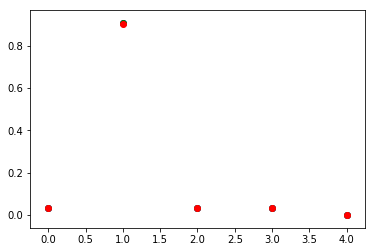

In [27]:
plt.scatter(range(len(imp)),imp['mean'],color = "blue")
plt.scatter(range(len(imp)),imp['mean'] + 2*imp['std'],color = "green")
plt.scatter(range(len(imp)),imp['mean'] - 2*imp['std'],color = "red")
## We can see from the scatter below that of the 5 clusters, the second is the most significant.
## the confidence intervals are also very tight.

In [28]:
### one thing we should also note is the varying length of the clusters:
divisor_list = []
for a,b in synthetic_clstrs.items():
    print(len(b))
    if len(b) >0:
        divisor_list.append(len(b))
    else:
        divisor_list.append(1)

83
2266
83
83
0


In [29]:
### Therefore if we weight the imp['mean'] by the length then this yields:


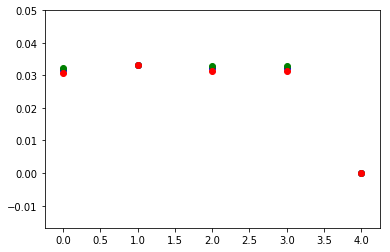

In [30]:
#Note hard codes in formula to enable better plotting
plt.scatter(range(len(imp)),imp['mean']*83/divisor_list,color = "blue")
plt.scatter(range(len(imp)),83*(imp['mean'] + 2*imp['std'])/divisor_list,color = "green")
plt.scatter(range(len(imp)),83*(imp['mean'] - 2*imp['std'])/divisor_list,color = "red")

In [31]:
### So now define the list variables we will use for opportunity classification:

In [32]:
output = stationary_data[one_pct_confidence_adf+y_variables_actual]

In [33]:
output_short = output[list(synthetic_clstrs[1]+y_variables_actual)]
output_short.reset_index(drop = True, inplace = True)

In [34]:
output_long = output[list(synthetic_clstrs[0]+
                          synthetic_clstrs[1]+
                          synthetic_clstrs[2]+
                          synthetic_clstrs[3]+
                          y_variables_actual
                         )]
output_long.reset_index(drop = True, inplace = True)

In [35]:
output_long.to_csv(path_or_buf = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\cleaned_matrices\technical_indicator_clean.csv")